In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
from Data.image_transforms import Image_Transforms
import cv2
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()



dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


/Users/gregory/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 128,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Tokenizer/230k_ver2.json',
                load_vocabulary = True,
                      image_padding = True,
                      max_width = 10*1000,


                 batch_size = 128,
                num_workers = 8,
                data_on_gpu = True,
                )

In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 581 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:


# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s

In [6]:
model = ResNetTransformer(dataset=dataset).to(dev)
# N_Inverted_128seq_1128Height_256embed_resnet34_4layers_8ratio_4
model.load_state_dict(torch.load(("Models_Parameters_Log/Resnet34_6trans_160height_2.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
lit_model.eval()
lit_model.freeze()
scripted_save = lit_model.to_torchscript()
torch.jit.save(scripted_save, "Models_Parameters_Log/scripted_model1.pt")


/Users/gregory/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/gregory/anaconda3/lib/python3.10/site-packages/torch/jit/_recursive.py:266: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


In [7]:
scripted = torch.jit.load("Models_Parameters_Log/scripted_model1.pt")

In [8]:
import albumentations
from albumentations.augmentations.geometric.resize import Resize
import torch.nn.functional as F

MAX_RATIO = 8
GOAL_HEIGHT = 160

def find_ratio(h, w, goal):
    return goal/h
    


def predict(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    #image = cv2.bitwise_not(image)
    h, w, c = image.shape
    ratio =w / h
    if ratio == 0:
        ratio = 1 
    if ratio > MAX_RATIO:
        ratio = MAX_RATIO
        
    new_h = GOAL_HEIGHT
    new_w = int(new_h * ratio)
    image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    
    max_H = 160
    max_W = 1280

    image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)

    
    print(image_tensor.shape)
    print(display(transform(image_tensor)))
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))



def predict_inverted(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    image = cv2.bitwise_not(image)
    
    ratio =w / h
    if ratio == 0:
        ratio = 1 
    if ratio > MAX_RATIO:
        ratio = MAX_RATIO
        
    
    new_h = GOAL_HEIGHT
    new_w = int(new_h * ratio)
    image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    
    max_H = 160
    max_W = 1280

    image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)

    
    print(image_tensor.shape)
    print(display(transform(image_tensor)))
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
    
    
def predict_simple(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    #ratio =w / h
    #if ratio == 0:
        #ratio = 1 
    #if ratio > MAX_RATIO:
        #ratio = MAX_RATIO
        ##new_h = GOAL_HEIGHT
        #new_w = int(new_h * ratio)
        #image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image']#[:1]
    print(display(transform(image_tensor)))
    
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
    
    
    
    
def predict_scaled(image_path):
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    ascpect = w/h
    if ascpect == 0:
        ascpect = 1 
    if ascpect > MAX_RATIO:
        ascpect = MAX_RATIO
    
    downscale = GOAL_HEIGHT/h
    image = cv2.resize(image, (0,0), fx=downscale, fy=downscale,interpolation=cv2.INTER_LINEAR)
   
    print(image.shape)
    



    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    max_H = 128
    max_W = 1024

    #if h<128 and w<1024:
        #image_tensor = F.pad(image_tensor, (0, max_W - w, 0, max_H - h), value=0)

    print(display(transform(image_tensor)))
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s
    

In [9]:
IMAGES= [#'Jupyter_Notebooks/test_photos/79a37d9d8b727e9.png',
         #"Jupyter_Notebooks/test_photos/S201.png",
          #"Jupyter_Notebooks/test_photos/202.png",
           "Jupyter_Notebooks/test_photos/203.png",
         "Jupyter_Notebooks/test_photos/qqq.png",
         "Jupyter_Notebooks/test_photos/zarhin.png",
         "Jupyter_Notebooks/test_photos/my_image.png",
         "Jupyter_Notebooks/test_photos/screenshot_1.png",
         "Jupyter_Notebooks/test_photos/screenshot_3.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_14.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_10.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_13.png",
          "Jupyter_Notebooks/test_photos/Screen Shot_11.png",
         "Jupyter_Notebooks/test_photos/screenshot_2.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_18.png",
        'Jupyter_Notebooks/test_photos/128.png',
         'Jupyter_Notebooks/test_photos/128_2.png',
         'Jupyter_Notebooks/test_photos/image_3.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_15.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_11.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_16.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_17.png',
         'Jupyter_Notebooks/test_photos/screenshot_2.png',
         'Jupyter_Notebooks/test_photos/ratio25.png',
         'Jupyter_Notebooks/test_photos/ratio31.png',
        'Jupyter_Notebooks/test_photos/ratio76.png',
         
    

]

(160, 475, 3)


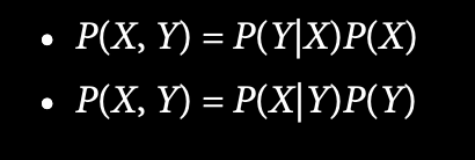

None
torch.Size([1, 160, 1280])


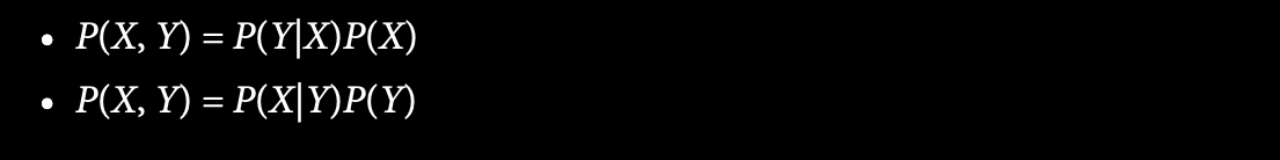

None

Predicted formula:
 <S> \begin{array} { l } { \bullet P ( X , \mathrm { Y } ) = P ( \mathrm { Y M P } ) P ( X ) } \\ { \cdots P ( X , \mathrm { Y } ) = P ( X | \mathrm { Y D } ) P ( \mathrm { Y } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 694, 3)


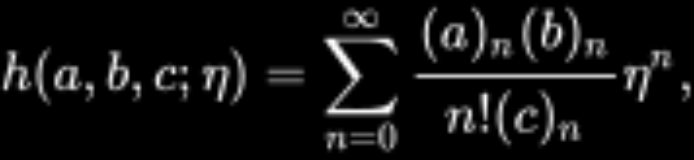

None
torch.Size([1, 160, 1280])


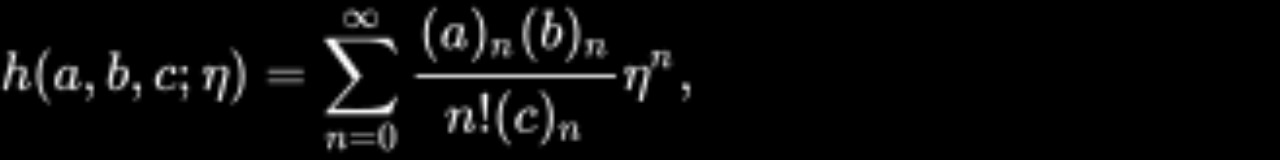

None

Predicted formula:
 <S> h ( a , b , c ; \eta ) = \sum _ { n = 0 } ^ { \infty } \frac { ( a ) _ { n } \{ b \} _ { n } } { n ! \{ c \} _ { n } } \eta ^ { n } , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 711, 3)


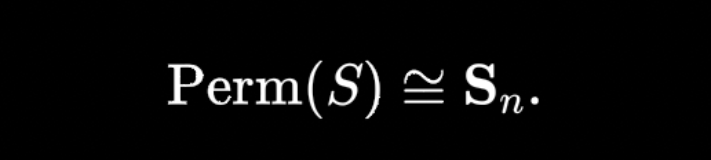

None
torch.Size([1, 160, 1280])


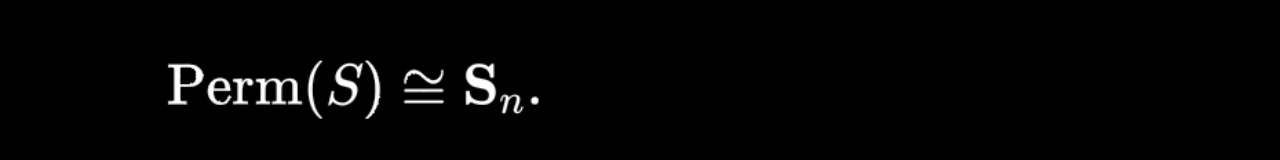

None

Predicted formula:
 <S> \mathrm { P e r m } ( S ) \cong { \bf S } _ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 605, 3)


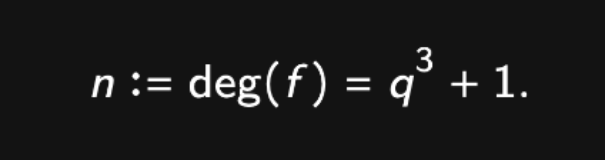

None
torch.Size([1, 160, 1280])


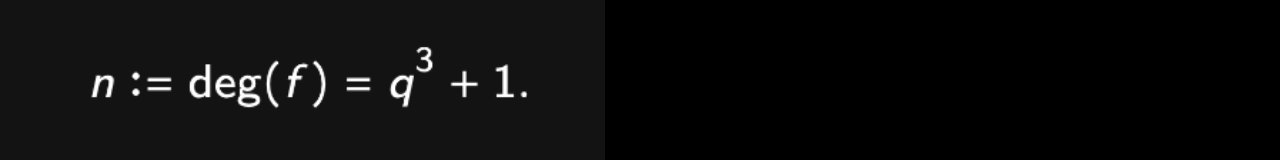

None

Predicted formula:
 <S> n : = \mathrm { d e g } ( f ) \, = \, { \bf g } ^ { 3 } + 1 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 692, 3)


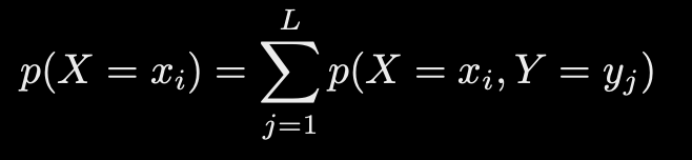

None
torch.Size([1, 160, 1280])


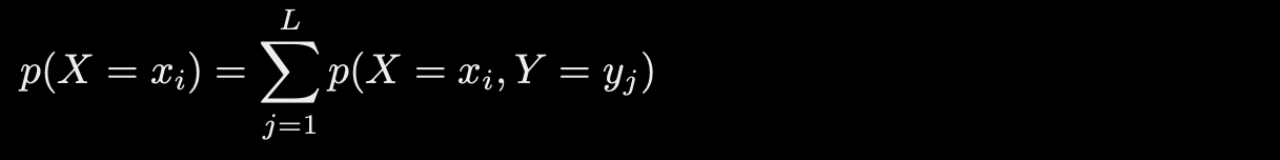

None

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 540, 3)


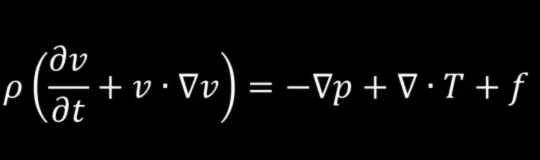

None
torch.Size([1, 160, 1280])


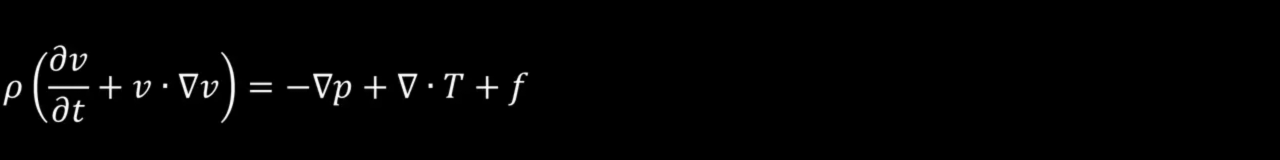

None

Predicted formula:
 <S> \rho \left( \frac { \partial v } { \partial t } + { \bf p } \cdot { \bf v } \right) = - \nabla p + { \bf \nabla } \cdot { \bf T } + f <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 1139, 3)


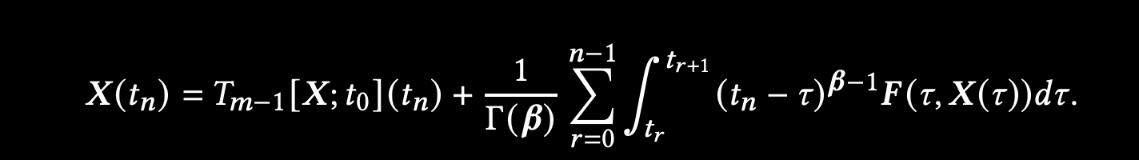

None
torch.Size([1, 160, 1280])


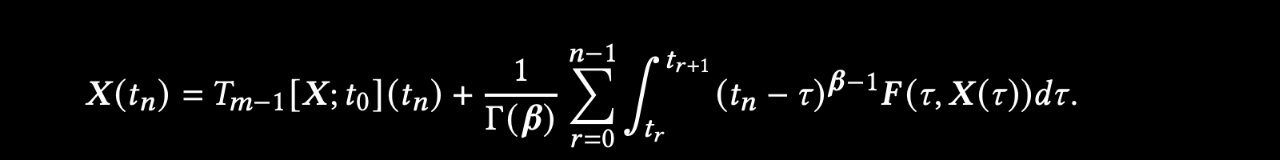

None

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \rho ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t r _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - \tau ) ^ { \rho - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 1280, 3)


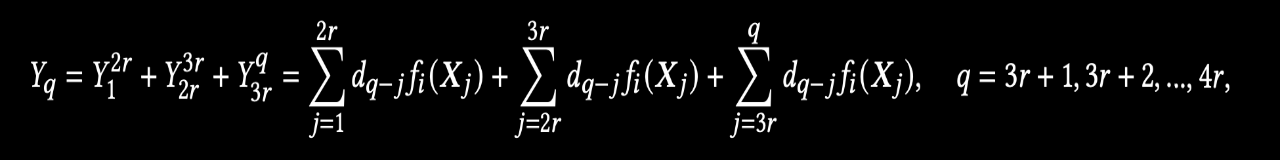

None
torch.Size([1, 160, 1280])


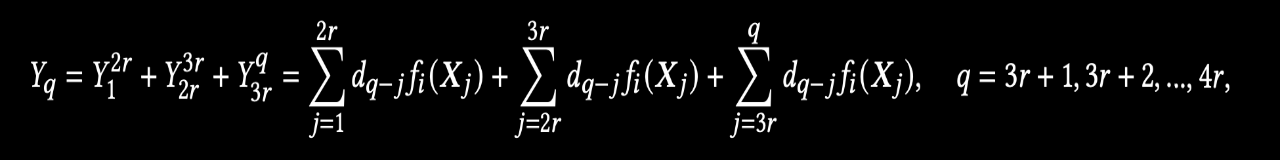

None

Predicted formula:
 <S> Y _ { q } = Y _ { 1 } ^ { 2 r } + Y _ { 2 r } ^ { 3 r } + Y _ { 2 r } ^ { q } = \sum _ { j = 1 } ^ { 2 r } d _ { q - j } f _ { i } ( X _ { j } ) + \sum _ { j = 2 r } ^ { 3 r } d _ { q - j } f _ { K } ( X _ { j } ) + \sum _ { j = 2 r } ^ { q } d _ { q - j } f _ { i }


<IPython.core.display.Math object>

None
(160, 1280, 3)


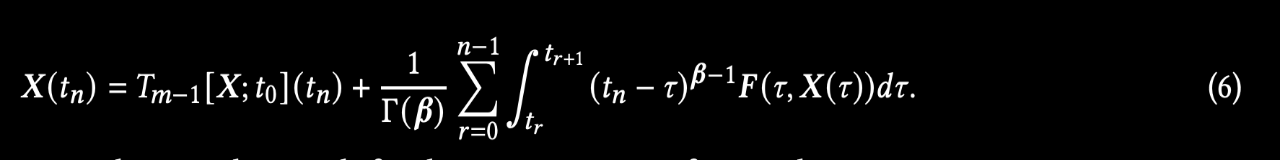

None
torch.Size([1, 160, 1280])


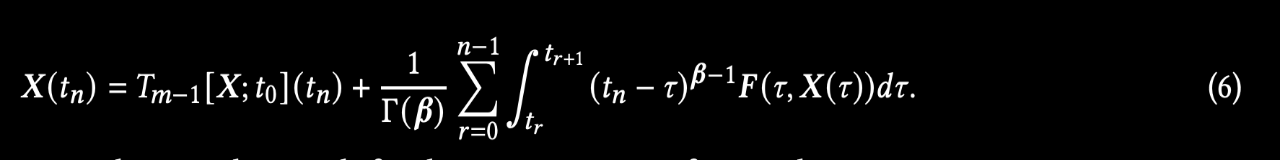

None

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \theta ) } \sum _ { \tau = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - \tau ) ^ { { \cal P } - 1 } F ( \tau , X ( \tau ) ) d \tau . \tag { 6 } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 338, 3)


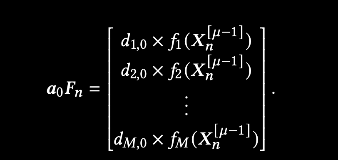

None
torch.Size([1, 160, 1280])


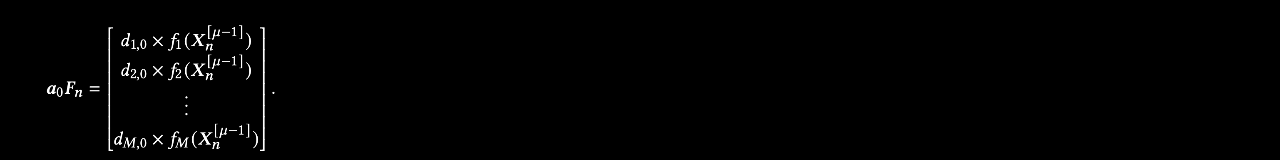

None

Predicted formula:
 <S> a _ { a } F _ { b } = \left[ \begin{array} { c } { d _ { a b } \times K _ { b } X _ { b } ^ { ( L - 1 ) } } \\ { d _ { a b } X _ { b } S _ { b } S _ { b } S _ { b } ^ { ( L - 1 ) } } \\ { d _ { b } X _ { b } S _ { b } S _ { b } S _ { b } S _ { b } S _ { b } ( X _ { b } ^ { ( L - 1


<IPython.core.display.Math object>

None
(160, 728, 3)


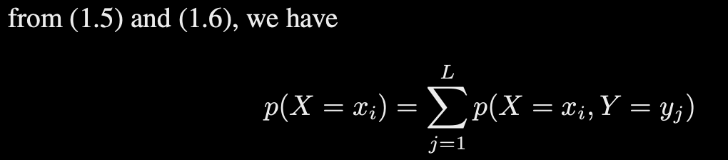

None
torch.Size([1, 160, 1280])


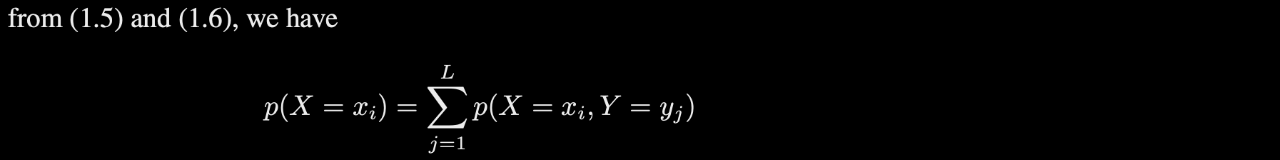

None

Predicted formula:
 <S> \mathrm { f o m } \left( 1 , 5 \right) \mathrm { a n d } \left( 1 , 6 \right) , \mathrm { w e } \right) = \sum _ { j = 1 } ^ { L } p \left( X = x _ { i } , Y = y _ { j } \right) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 960, 3)


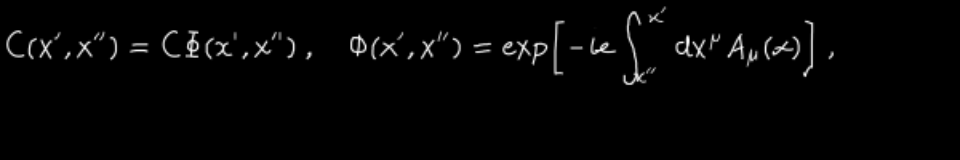

None
torch.Size([1, 160, 1280])


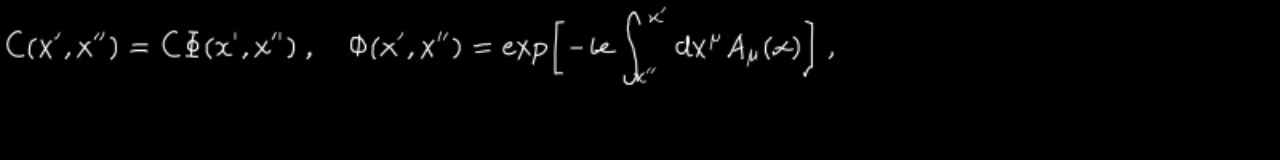

None

Predicted formula:
 <S> \begin{array} { l } { \subset \{ \chi ^ { \prime } , \lambda ^ { \prime } \} \, = \, \subset \, \Phi ( \chi ^ { \prime } , \chi ^ { \prime } ) \, \, \, \, \, \, \, \, \, \, \, \Theta ( \chi ^ { \prime } , \chi ^ { \prime } ) \, = \, \varphi [ - \omega \, \sum _ { \cal X } ^ { \infty } \, \mathrm { d } \chi ^ { \prime } \, \phi _ { \mu } ( \varphi ) ] \, \, . } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 285, 3)


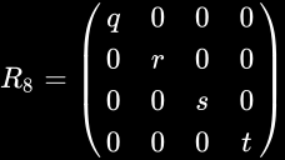

None
torch.Size([1, 160, 1280])


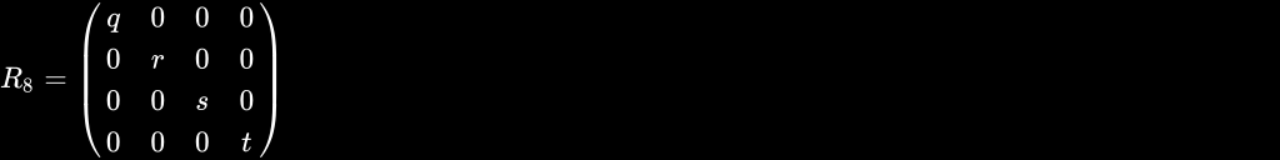

None

Predicted formula:
 <S> R _ { 8 } = \left( \begin{array} { c c c c } { q } & { 0 } & { 0 } & { 0 } \\ { 0 } & { r } & { 0 } & { 0 } \\ { 0 } & { 0 } & { s } & { t } \\ { 0 } & { 0 } & { 0 } & { t } \\ \end{array} \right) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 1280, 3)


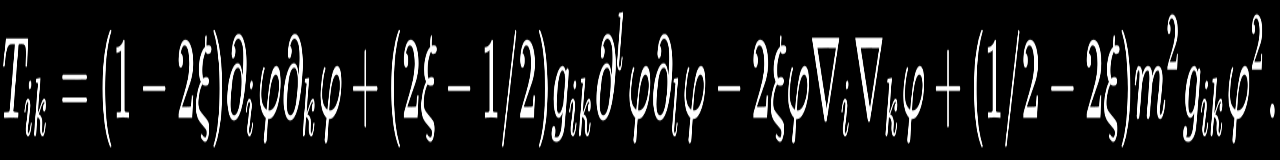

None
torch.Size([1, 160, 1280])


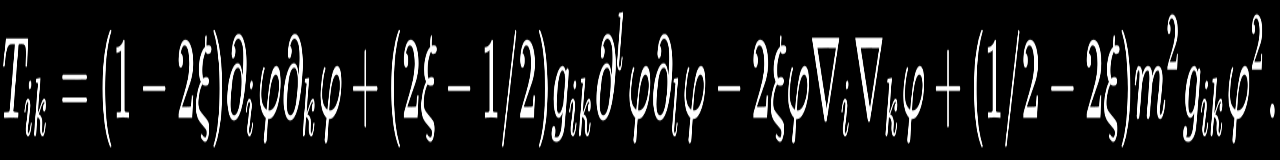

None

Predicted formula:
 <S> T _ { i k } = ( 1 - 2 \xi ) \partial _ { i } \varphi \partial _ { k } \varphi + ( 2 \xi - 1 / 2 ) g _ { i k } \partial ^ { \prime } \varphi \partial _ { i } \varphi - 2 \xi \varphi \nabla _ { i } \nabla _ { k } \varphi + ( 1 / 2 - 2 \xi ) m ^ { 2 } g _ { i k } \varphi ^ { 2 } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 908, 3)


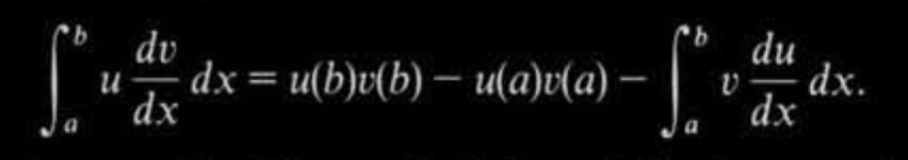

None
torch.Size([1, 160, 1280])


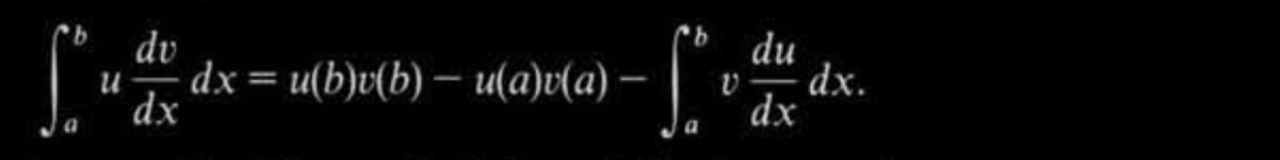

None

Predicted formula:
 <S> { \int _ { a } ^ { b } u { \frac { d v } { d \chi } } \, d \chi = u ( b ) v ( b ) - u ( a ) v ( d ) - { \int _ { a } ^ { b } v } { \frac { d u } { d \chi } } \, d \chi . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 1187, 3)


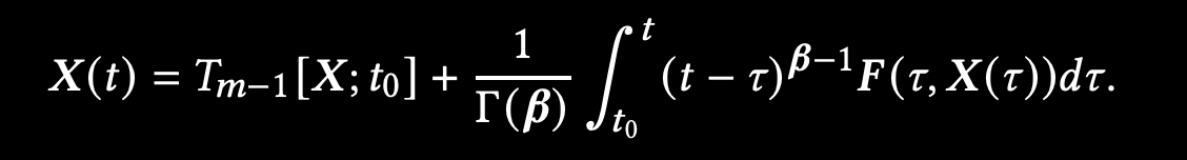

None
torch.Size([1, 160, 1280])


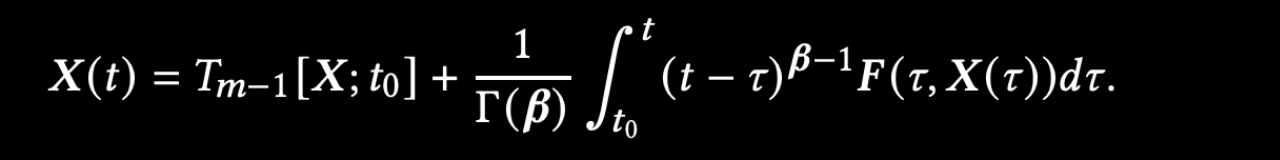

None

Predicted formula:
 <S> X ( t ) = T _ { m - 1 } [ X ; t _ { 0 } ] + \frac { 1 } { \Gamma ( { \cal { B } } ) } \int _ { t _ { 0 } } ^ { t } ( t - \tau ) ^ { { \cal { F } } - 1 } F ( \tau , X ( \tau ) ) d \, \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 338, 3)


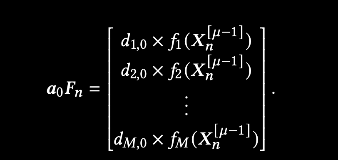

None
torch.Size([1, 160, 1280])


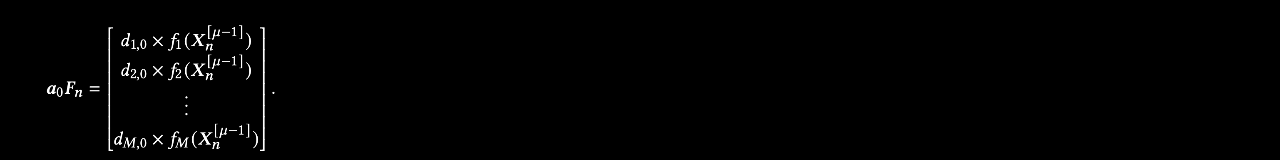

None

Predicted formula:
 <S> a _ { a } F _ { b } = \left[ \begin{array} { c } { d _ { a b } \times K _ { b } X _ { b } ^ { ( L - 1 ) } } \\ { d _ { a b } X _ { b } S _ { b } S _ { b } S _ { b } ^ { ( L - 1 ) } } \\ { d _ { b } X _ { b } S _ { b } S _ { b } S _ { b } S _ { b } S _ { b } ( X _ { b } ^ { ( L - 1


<IPython.core.display.Math object>

None
(160, 960, 3)


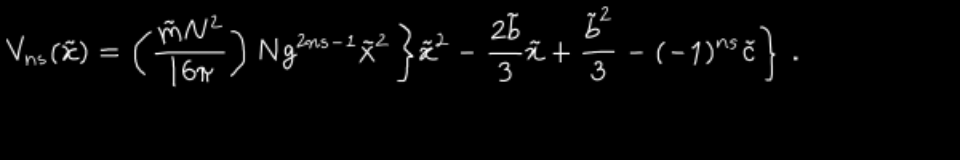

None
torch.Size([1, 160, 1280])


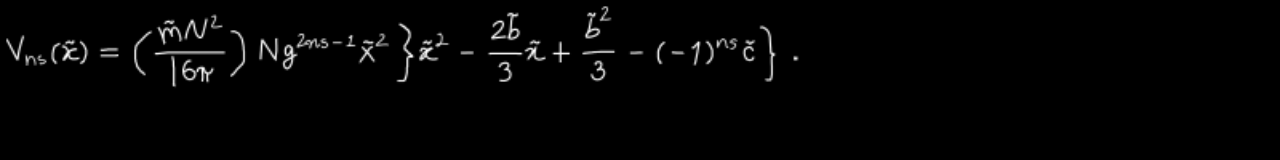

None

Predicted formula:
 <S> \chi _ { \mathrm { o n } } ( \tilde { \cal E } ) = \left( \frac { \tilde { \nabla } \sqrt { 2 } } { | 6 \pi } \right) \propto 9 ^ { 2 m _ { s } - 4 } \tilde { \lambda } ^ { 2 m _ { s } - 4 } \tilde { \lambda } \hat { \xi } + \frac { \tilde { x } ^ { 2 } } { 2 } - [ - f ) ^ { \mathrm { o r } } \tilde { \xi } \right) \ . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 960, 3)


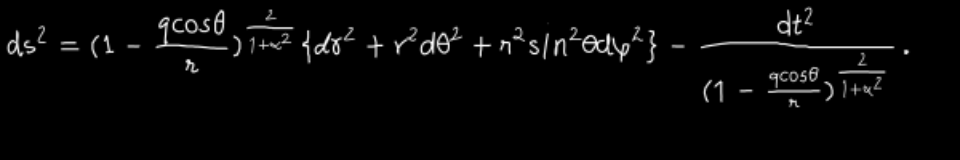

None
torch.Size([1, 160, 1280])


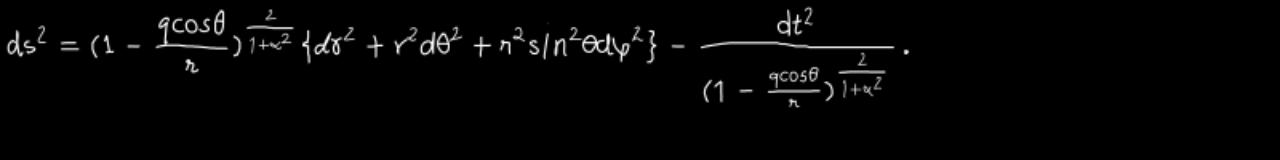

None

Predicted formula:
 <S> \mathrm { d s } ^ { 2 } = ( 1 - \mathrm { ~ f o s } s ) ^ { \frac { 2 } { 1 + \omega } } \langle s k ^ { 2 } + V ^ { 2 } s | \alpha ^ { 2 } + m ^ { 2 } \mathrm { s } / n ^ { 2 } \mathrm { e u } \psi ^ { s } \} ~ - ~ \frac { \mathrm { s t e s t s t } } { \sqrt { 1 ~ - ~ \frac { \mathrm { s t s t s } } { \infty } ) | + \mathrm { s t } } ~ .


<IPython.core.display.Math object>

None
(160, 728, 3)


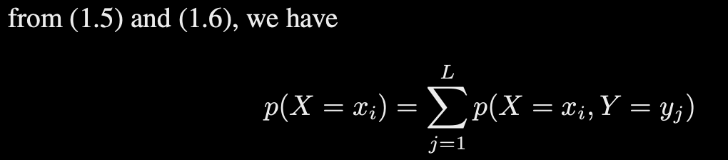

None
torch.Size([1, 160, 1280])


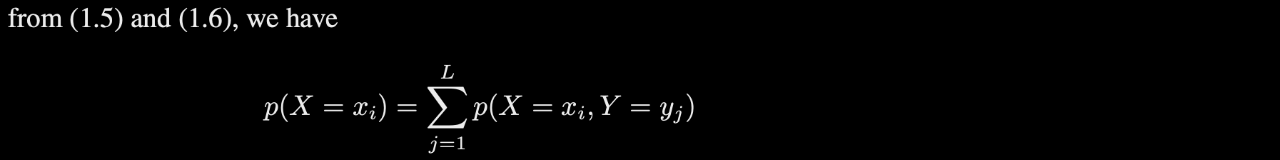

None

Predicted formula:
 <S> \mathrm { f o m } \left( 1 , 5 \right) \mathrm { a n d } \left( 1 , 6 \right) , \mathrm { w e } \right) = \sum _ { j = 1 } ^ { L } p \left( X = x _ { i } , Y = y _ { j } \right) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 1280, 3)


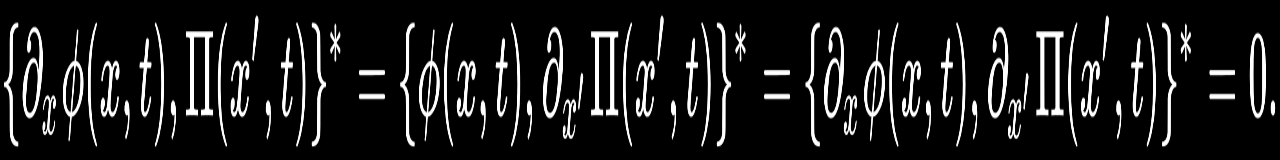

None
torch.Size([1, 160, 1280])


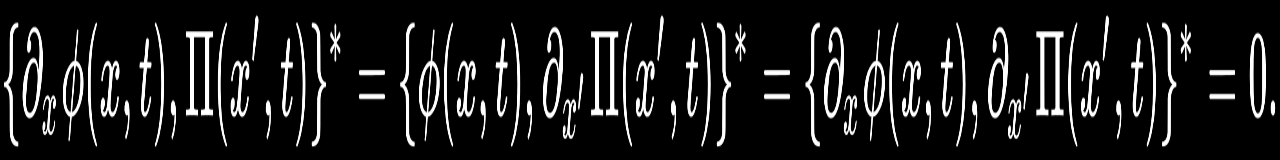

None

Predicted formula:
 <S> \{ \partial _ { x } \phi ( x , t ) , \Pi ( x ^ { \prime } , t ) \} ^ { * } = \{ \phi ( x , t ) , \partial _ { x ^ { \prime } } \Pi ( x ^ { \prime } , t ) \} ^ { * } = \{ \partial _ { x } \phi ( x , t ) , \partial _ { x ^ { \prime } } \Pi ( x ^ { \prime } , t ) \} ^ { * } = 0 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 1280, 3)


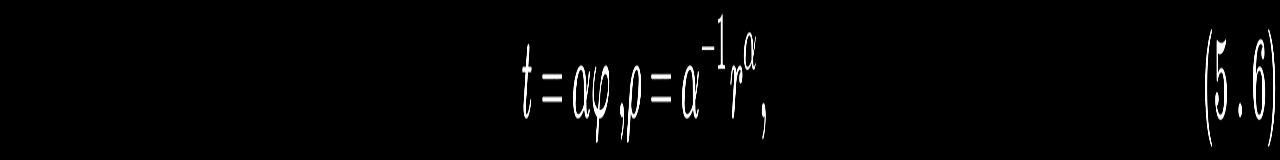

None
torch.Size([1, 160, 1280])


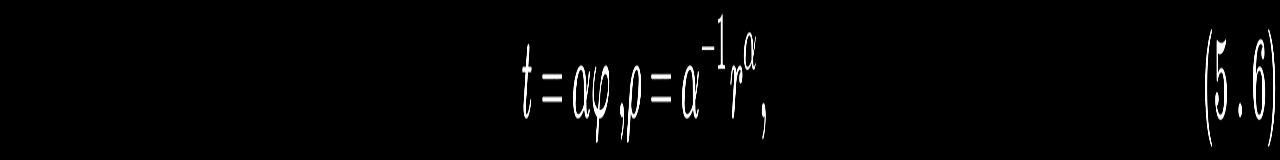

None

Predicted formula:
 <S> t = \alpha \varphi \, , \rho = \alpha ^ { - 1 } r ^ { \alpha } , \tag { 5 . 6 } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 1280, 3)


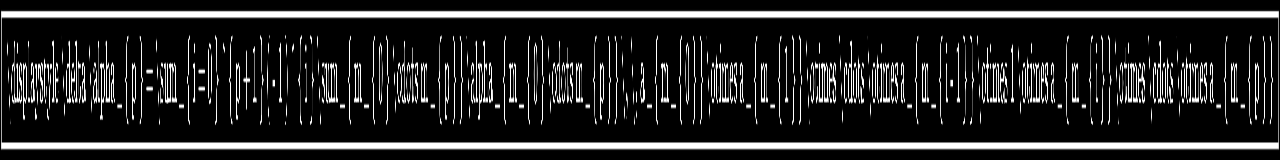

None
torch.Size([1, 160, 1280])


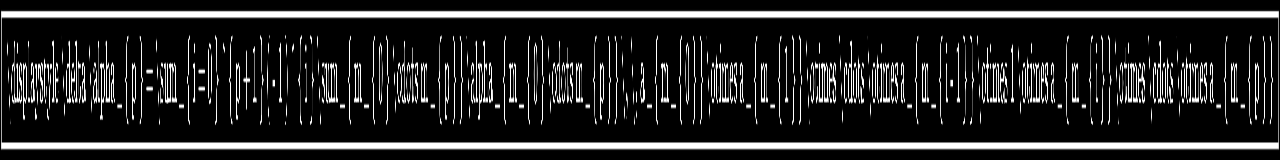

None

Predicted formula:
 <S> \fbox { A } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } \\ { { } & { } & { } & { } & { } & { } & { } & { } & { } \\ { { } & { } & { } & { } & { } & { } & { } & { } & { { } } & { { } & { } & { } & { { } & { } & { } & { { } & { { }


<IPython.core.display.Math object>

None


In [10]:
for image in IMAGES:
    predict(image)

(138, 410, 3)


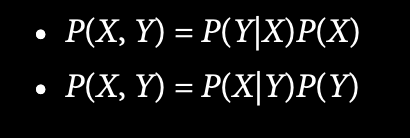

None
torch.Size([3, 138, 410])

Predicted formula:
 <S> \begin{array} { l l } { \bullet P ( X , Y ) = P ( \Psi , Y ) = P ( Y X , Y ) = P ( Y X ) P ( X ) } \\ { \cdots P ( X , Y ) = P ( X , Y ) = P ( X , Y ) = P ( X , Y ) D ( Y ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(41, 178, 3)


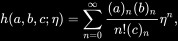

None
torch.Size([3, 41, 178])

Predicted formula:
 <S> \hat { a ( a , t , t ) = \sum \frac { \sum _ i a s i n } \frac { n s u s t , n + p - \sum \leq \frac \sum \leq \sum \frac \sum n \leq n \leq \frac n n n ( n s n n n n n n n n } n _ n n n n n n n n } N n _ n n n n n n n n n n n } N n \leq \frac \sum _ { n \leq n \leq n \leq n \leq n \leq n \leq n \leq n \leq n \leq n \leq n \leq n \leq n \leq n \leq n \leq n \leq n \leq


<IPython.core.display.Math object>

None
(116, 516, 3)


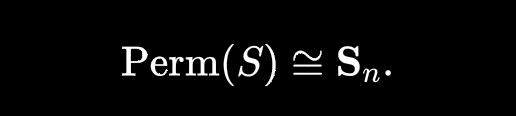

None
torch.Size([3, 116, 516])

Predicted formula:
 <S> \mathrm { P e r m } ( S ) \cong { \bf S } _ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(112, 424, 3)


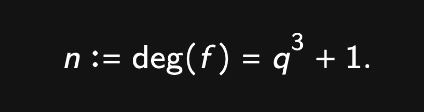

None
torch.Size([3, 112, 424])

Predicted formula:
 <S> m : = \mathrm { d e g } ( f ) = q ^ { 3 } + 1 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(152, 658, 3)


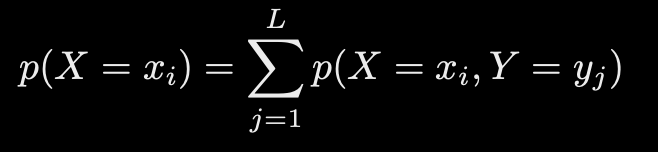

None
torch.Size([3, 152, 658])

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = x _ { i } , Y = y _ { j } ) \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; p = y _ { j } ) \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; p ( X = x _ { j } ) \; \; \; \; \; \; \; \; \; \; \; \; \;


<IPython.core.display.Math object>

None
(320, 1080, 3)


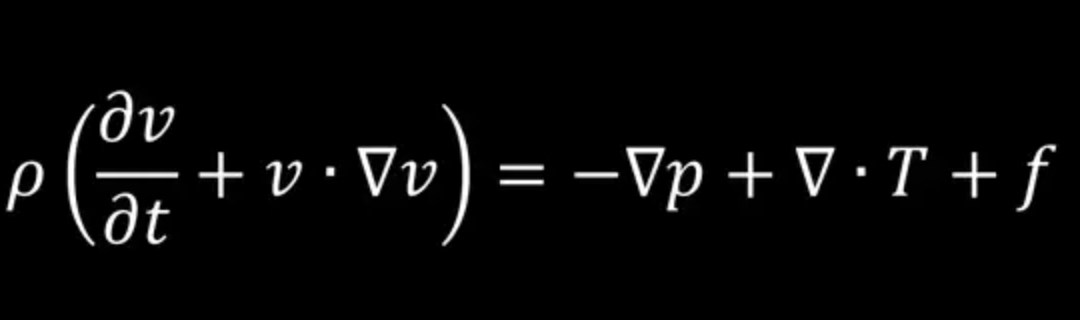

None
torch.Size([3, 320, 1080])

Predicted formula:
 <S> \rho \left( \frac { \partial { \bf v } } { \partial { \bf t } } + { \bf v } \cdot { \bf \nabla } { \bf p } \right) = - { \bf \nabla p } + { \bf \nabla } \cdot { \bf F } + f <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(200, 1424, 3)


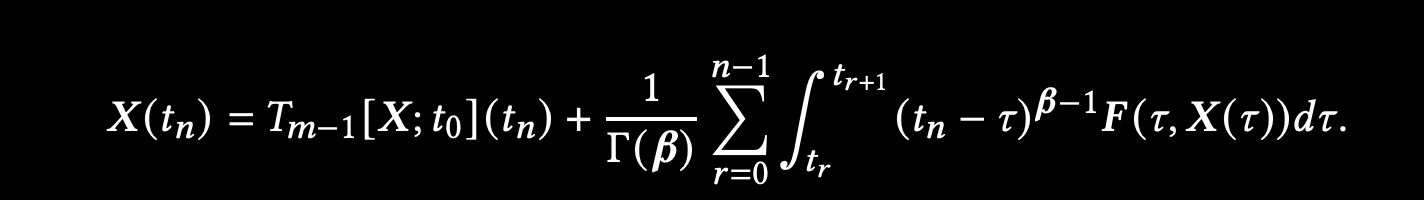

None
torch.Size([3, 200, 1424])

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } X ; t _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \beta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - \tau ) ^ { \rho - 1 } F ( \tau , X ( \tau ) ) ^ { \theta - 1 } F ( \tau , X ( \tau ) ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(188, 1950, 3)


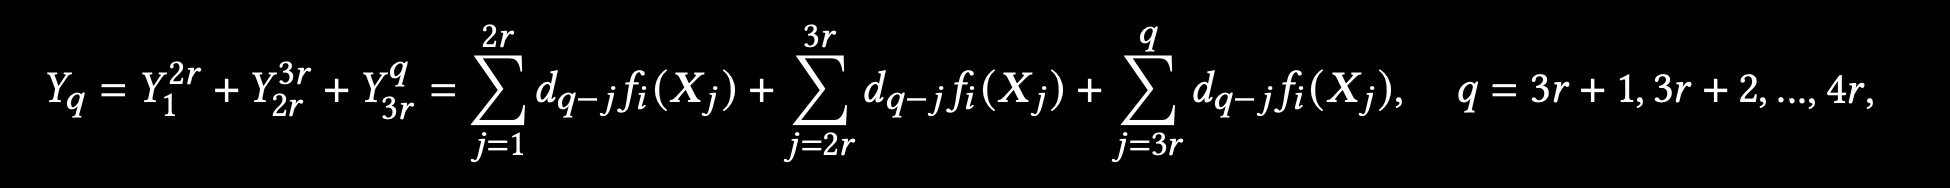

None
torch.Size([3, 188, 1950])

Predicted formula:
 <S> Y _ { q } = Y _ { 1 } ^ { 2 r } + Y _ { 2 r } ^ { 3 r } + Y _ { 3 r } ^ { q } = \sum _ { j = 1 } ^ { 2 r } d _ { q - j } f _ { i } ( X _ { j } ) + \sum _ { j = 2 r } ^ { 3 r } d _ { q - j } f _ { i } ( X _ { j } ) + \sum _ { j = 3 r } ^ { q } \, d _ { q - j } ( X _ {


<IPython.core.display.Math object>

None
(202, 1774, 3)


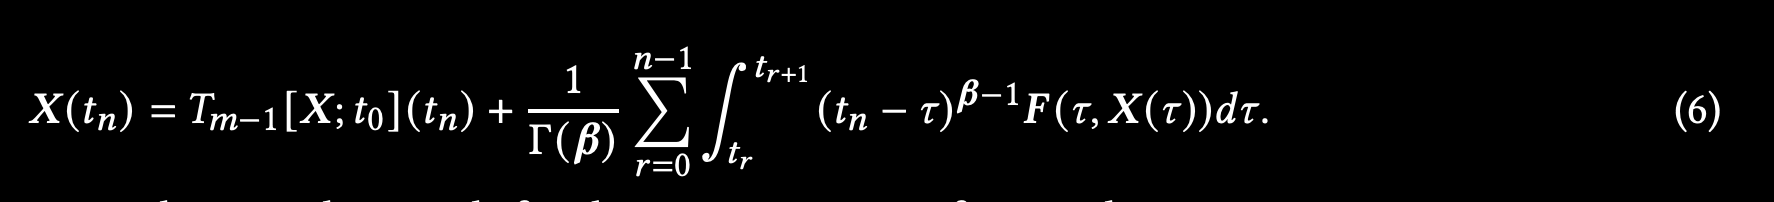

None
torch.Size([3, 202, 1774])

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \beta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - \tau ) ^ { \beta - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(384, 812, 3)


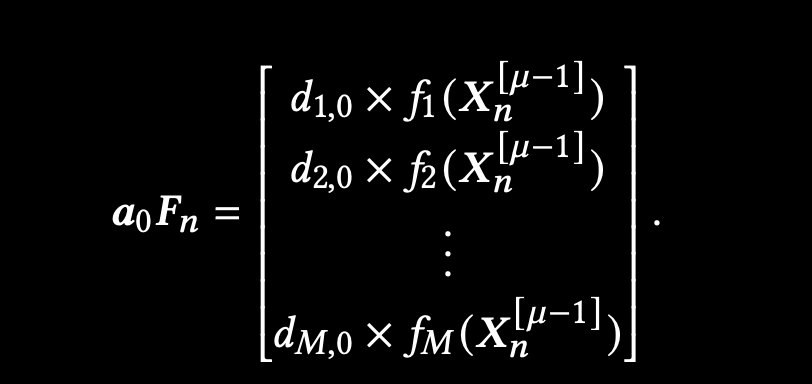

None
torch.Size([3, 384, 812])

Predicted formula:
 <S> \begin{array} { c c } { a _ { 0 } F _ { n } = } \\ { d _ { 2 , 0 } \times f _ { 3 } ( X _ { n - 1 } ^ { [ \mu - 1 ] } ) } \\ \end{array} \bigg | <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(224, 1020, 3)


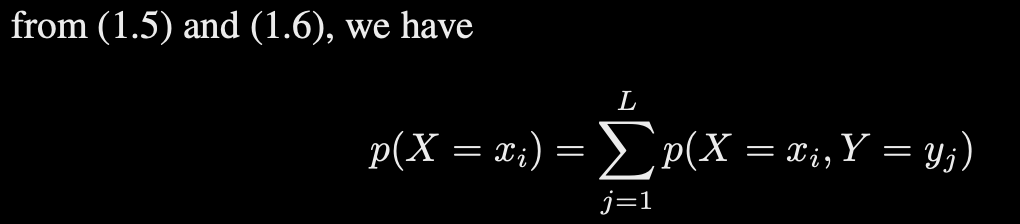

None
torch.Size([3, 224, 1020])

Predicted formula:
 <S> \mathrm { f o m ~ ( 1 , 5 ) ~ a n d v e } \qquad p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(100, 600, 3)


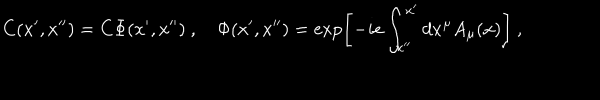

None
torch.Size([3, 100, 600])

Predicted formula:
 <S> \{ \zeta / N ^ { \prime } , N ^ { \prime } \} = \{ S ( K , \chi ^ { \prime } ) , \quad a ( N , N ^ { \prime } ) = \varepsilon s [ - \Lambda _ { \lambda } ^ { \infty } \omega ^ { \prime } A ^ { \prime } f ^ { \prime } , ( \mu ) ] } = \varepsilon _ { \lambda } [ - \omega _ { \lambda } ^ { \infty } \omega ^ { \prime } A ^ { \prime } f ^ { \prime } , \mu _ { \mu } ( e ) ] - \varepsilon _ { 1 } , \quad u , \quad n <


<IPython.core.display.Math object>

None
(128, 228, 3)


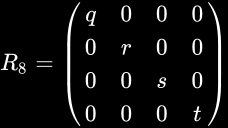

None
torch.Size([3, 128, 228])

Predicted formula:
 <S> R _ { 8 } = \left( \begin{array} { c c c c c } { q } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { r } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0


<IPython.core.display.Math object>

None
(128, 3260, 3)


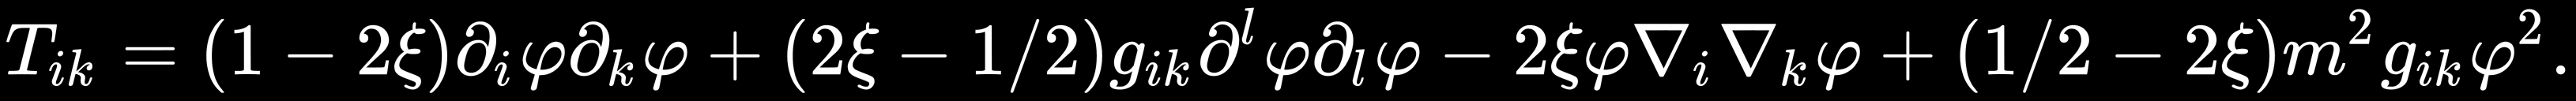

None
torch.Size([3, 128, 3260])

Predicted formula:
 <S> T _ { i k } = ( 1 - 2 \xi ) \partial _ { i } \varphi \partial _ { k } \varphi + ( 2 \xi - 1 / ( 2 \xi - 1 ) ( 2 \xi - 1 ) . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(150, 852, 3)


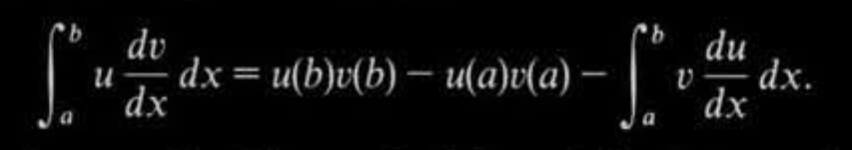

None
torch.Size([3, 150, 852])

Predicted formula:
 <S> \int _ { a } ^ { b } u \, \frac { d v } { d \chi } \, d \chi = u ( b ) v ( b ) - u ( d ) v ( d ) - \int _ { a } ^ { b } \, v \, \frac { d u } { d \chi } \, d \chi \, . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(152, 1128, 3)


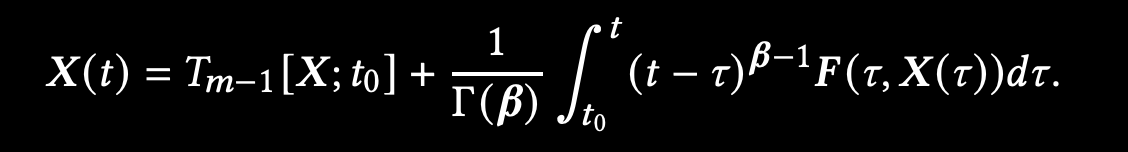

None
torch.Size([3, 152, 1128])

Predicted formula:
 <S> X ( t ) = T _ { m - 1 } [ X ; t _ { 0 } ] + \frac { 1 } { \Gamma ( \beta ) } \int _ { t _ { 0 } } ^ { t } ( t - \tau ) ^ { \beta - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(384, 812, 3)


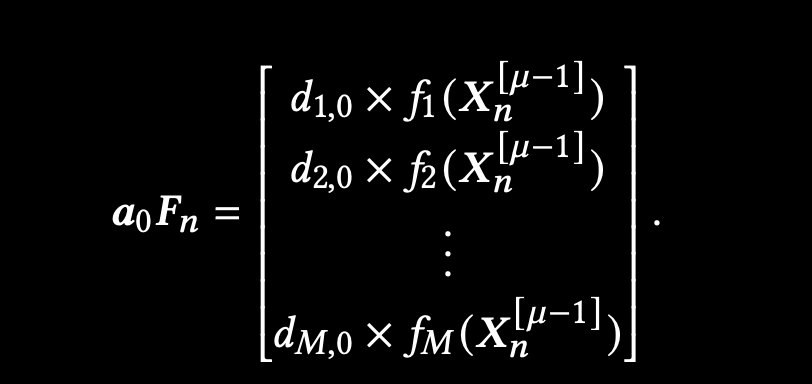

None
torch.Size([3, 384, 812])

Predicted formula:
 <S> \begin{array} { c c } { a _ { 0 } F _ { n } = } \\ { d _ { 2 , 0 } \times f _ { 3 } ( X _ { n - 1 } ^ { [ \mu - 1 ] } ) } \\ \end{array} \bigg | <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(100, 600, 3)


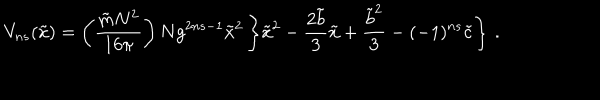

None
torch.Size([3, 100, 600])

Predicted formula:
 <S> V _ { n _ { n } ( N ) = ( \frac { N ( N ) } { 1 } ) \times 3 p ^ { 2 n - 1 } } { \vdots } _ { n ^ { 2 } - \frac { 2 k } { 2 } } { \cal F } ^ { 2 } - \frac { 2 k } { 2 k } { \cal K } _ { n - 1 } \frac { k ^ { 2 } } { 2 } - \frac { 2 k } { 2 } { \cal K } _ { n } + \frac { k ^ { 2 } } { 2 } - \frac { k } {


<IPython.core.display.Math object>

None
(100, 600, 3)


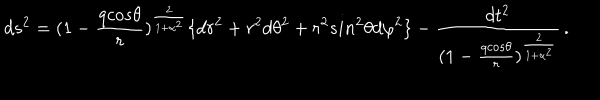

None
torch.Size([3, 100, 600])

Predicted formula:
 <S> { \hat { A } ^ { 2 } = ( 1 - \frac { 4 8 8 } { 1 } ) + 1 , \pm } ( k ^ { 2 } + \frac { 4 8 6 } { 1 , + 1 } ) + 1 , 1 , 2 } ( k ^ { 2 8 \alpha ^ { 2 } } - \frac { 8 \pi \alpha ^ { 2 } } { 1 / 6 } ) ^ { - \frac { 8 } { 4 } \alpha \beta \alpha ^ { 2 } } - \frac { 8 \pi \alpha \beta ^ { 2 } } { 2 } - \frac { 8 \pi \alpha \beta \alpha ^ { 2 }


<IPython.core.display.Math object>

None
(224, 1020, 3)


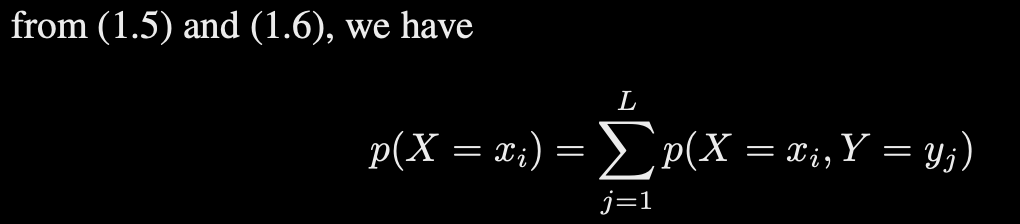

None
torch.Size([3, 224, 1020])

Predicted formula:
 <S> \mathrm { f o m ~ ( 1 , 5 ) ~ a n d v e } \qquad p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 3264, 3)


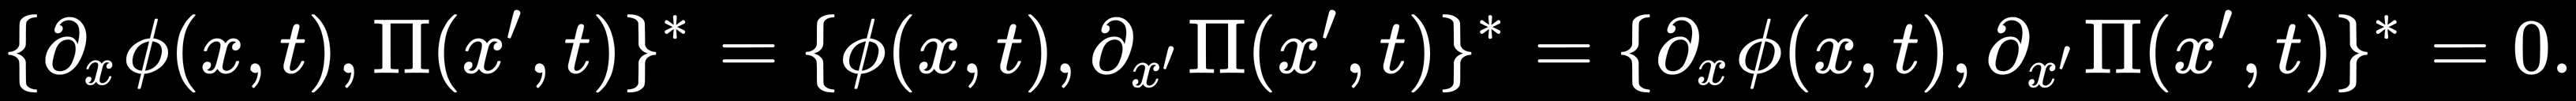

None
torch.Size([3, 128, 3264])

Predicted formula:
 <S> \{ \partial _ { x } \phi ( x , t ) , \Pi ( x ^ { \prime } , t ) \} ^ { * } = \{ \phi ( x , t ) \} ^ { * } = \{ \phi ( x , t ) ( x , t ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 4042, 3)


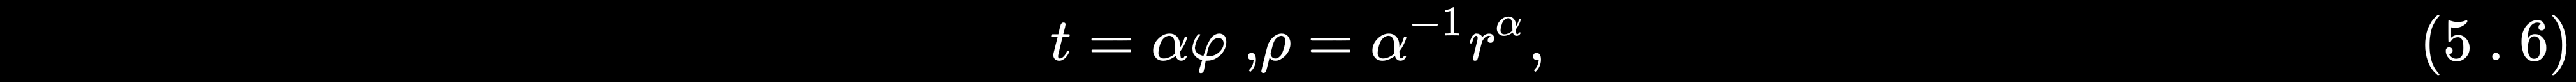

None
torch.Size([3, 128, 4042])

Predicted formula:
 <S> ( 5 \cdot ) = \alpha \varphi \; , \rho = \alpha \varphi \; , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 9794, 3)


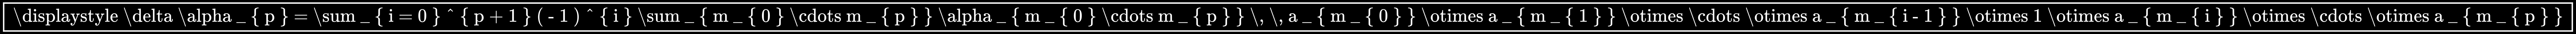

None
torch.Size([3, 128, 9794])

Predicted formula:
 <S> \Box \square \mathrm { d i s p l a y s t y l e } \oplus \mathrm { a l p h a - \{ p ~ } \} = <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [13]:
for image in IMAGES:
    predict_simple(image)

(160, 475, 3)


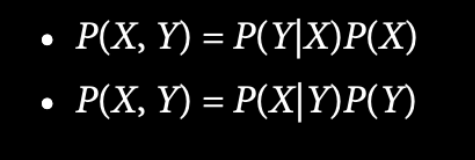

None
torch.Size([1, 160, 475])

Predicted formula:
 <S> \begin{array} { l l } { \bullet P ( X , \Psi ) = P ( \Psi X , \Psi ) = P ( Y X ) P ( X ) } \\ { \cdots P ( X , Y ) = P ( X , Y ) = P ( X , \Psi ) P ( Y ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 695, 3)


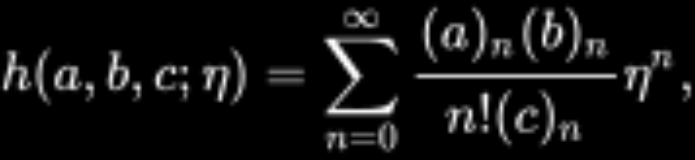

None
torch.Size([1, 160, 695])

Predicted formula:
 <S> h ( a , b , c ; \eta ) = \sum _ { n = 0 } ^ { \infty } \frac { ( a ) _ { n } \{ b \} _ { n } \{ b \} _ { n } } { n ! \{ c ^ { \prime } \} _ { n } ! ( c ^ { \prime } \} _ { n } } \eta ^ { \pi n } , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 712, 3)


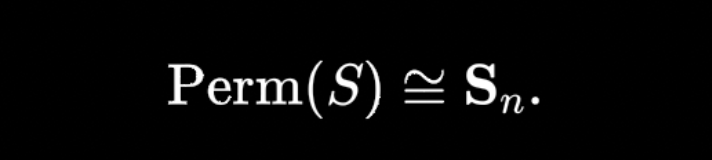

None
torch.Size([1, 160, 712])

Predicted formula:
 <S> \mathrm { P e r m } ( S ) \cong { \bf S } _ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 606, 3)


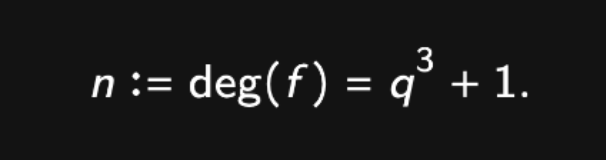

None
torch.Size([1, 160, 606])

Predicted formula:
 <S> m : = \mathrm { d e g } ( f ) \, = \, { \bf g } ^ { 3 } + 1 \, { \bf 1 } \, . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 693, 3)


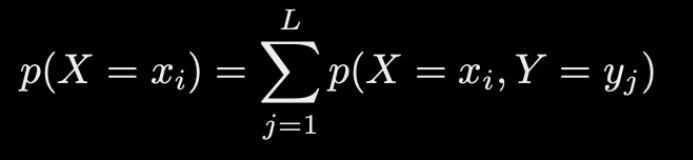

None
torch.Size([1, 160, 693])

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = x _ { i } , Y = y _ { j } ) \quad . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 540, 3)


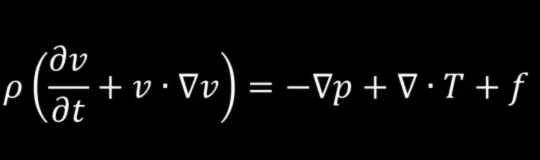

None
torch.Size([1, 160, 540])

Predicted formula:
 <S> \rho \left( \frac { \partial v } { \partial t } + { \bf p } \cdot { \bf v } \right) = - \nabla p + { \bf v } \cdot { \bf v } \right) = - \nabla p + { \bf \nabla } \cdot { \bf v } \cdot { \bf v } + { \bf \nabla } \cdot { \bf T } + f + f <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 1139, 3)


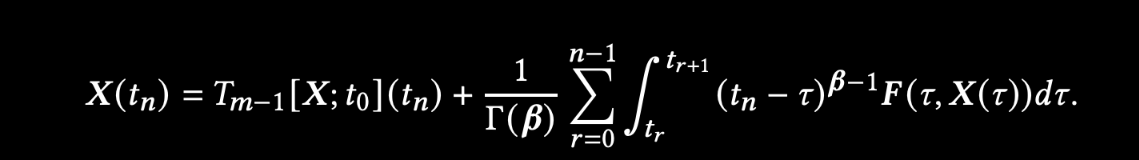

None
torch.Size([1, 160, 1139])

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \rho ) } \sum _ { \pi = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - \tau ) ^ { \rho - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 1660, 3)


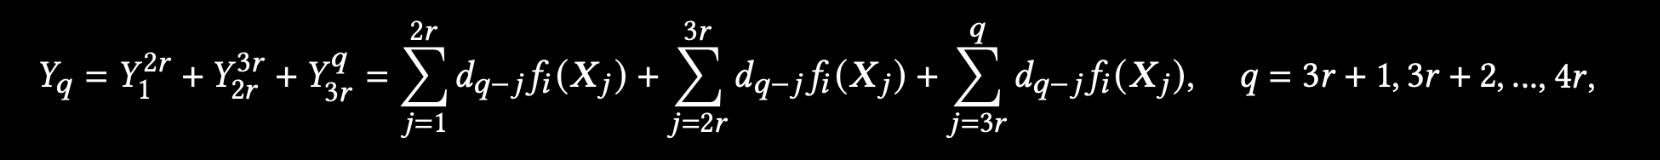

None
torch.Size([1, 160, 1660])

Predicted formula:
 <S> Y _ { q } = Y _ { 1 } ^ { 2 r } + Y _ { 2 r } ^ { 3 r } + Y _ { 3 r } ^ { q } = \sum _ { j = 1 } ^ { 2 r } d q - j f _ { i } ( X _ { j } ) + \sum _ { j = 2 r } ^ { 3 r } d _ { q - j } f _ { i } ( X _ { j } ) + \sum _ { j = 3 r } ^ { q } d _ { q - j } f _ { i } ( X _


<IPython.core.display.Math object>

None
(160, 1405, 3)


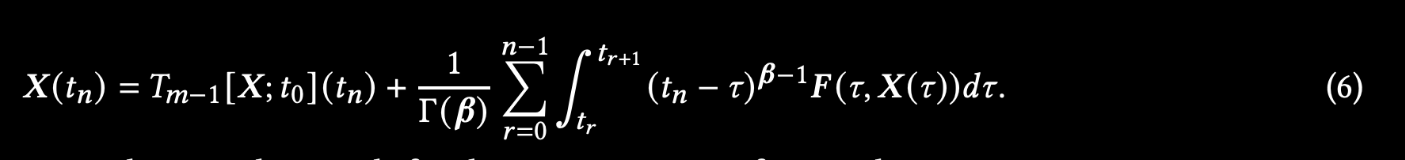

None
torch.Size([1, 160, 1405])

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \beta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t r } ^ { t _ { r } + 1 } ( t _ { n } - \tau ) ^ { \beta - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 338, 3)


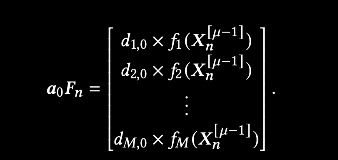

None
torch.Size([1, 160, 338])

Predicted formula:
 <S> a _ { u } F _ { n } = \left[ \begin{array} { c } { d u _ { 1 } \times K _ { 2 } K ( X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } ^ { ( L - 1 ) } } \\ { d _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { i } X _


<IPython.core.display.Math object>

None
(160, 729, 3)


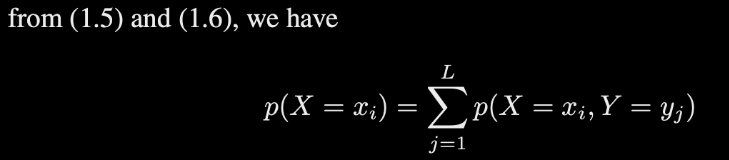

None
torch.Size([1, 160, 729])

Predicted formula:
 <S> \mathrm { f o m } \left( 1 , 5 \right) \mathrm { a n d } \left( 1 , 6 \right) , \mathrm { w e n e } \right) \sum _ { j = 1 } ^ { L } p \left( X = x _ { i } \right) = \sum _ { j = 1 } ^ { L } p \left( X = x _ { i } , Y = y _ { j } \right) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 960, 3)


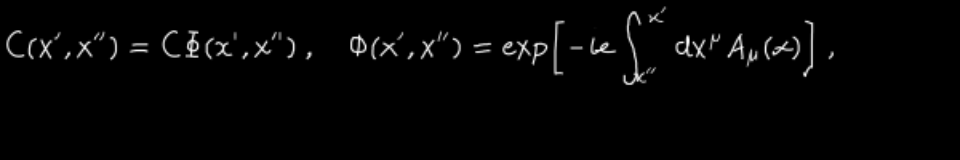

None
torch.Size([1, 160, 960])

Predicted formula:
 <S> \begin{array} { l l } { \subset \{ \chi ^ { \prime } , \lambda ^ { \prime } \} } \\ { \subset \{ \chi ^ { \prime } , \lambda ^ { \prime } \} } \\ \end{array} = \subset { \bf g } ( { \bf K } ^ { \prime } , { \cal A } ^ { \prime } ) \ \ \ \ \ \ \Theta ( { \cal N } , { \cal N } ^ { \prime } ) \ \ \ \ \ \ \ \ \Theta ( { \cal K } , { \cal N } ^ { \prime } ) \ = e { \cal X } _ { \cal L } ^ { \prime } \ {


<IPython.core.display.Math object>

None
(160, 285, 3)


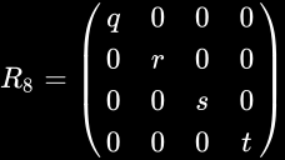

None
torch.Size([1, 160, 285])

Predicted formula:
 <S> R _ { 8 } = \left( \begin{array} { c c c c c } { q } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { r } & { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { s } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } & { t } & { t } \\ { 0 } & { 0 } & { 0 } & { 0


<IPython.core.display.Math object>

None
(160, 4075, 3)


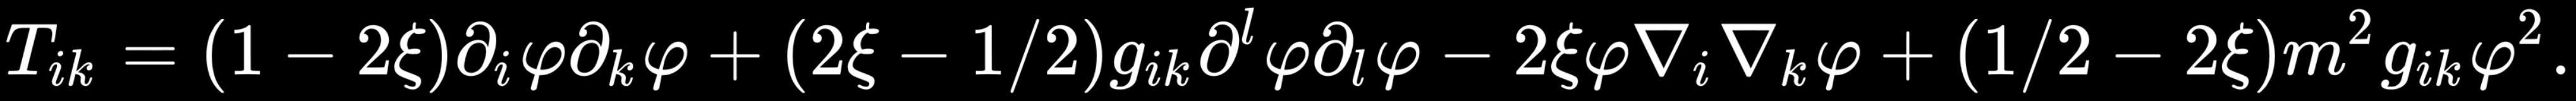

None
torch.Size([1, 160, 4075])

Predicted formula:
 <S> T _ { i k } = ( 1 - 2 \xi ) \partial _ { i } \varphi \partial _ { k } \varphi + ( 2 \xi ) + ( 2 \xi \varphi + ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 909, 3)


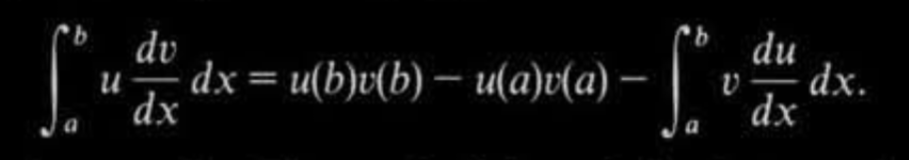

None
torch.Size([1, 160, 909])

Predicted formula:
 <S> { \displaystyle { \displaystyle { \displaystyle \displaystyle { \displaystyle { \displaystyle { \int } _ { a } } ^ { b } } } u { \frac { { d v } { { A } } } } \, { { { \mit { X } } } } } \, { { { \bf { X } } } } = u ( b ) { { \psi } } ( { b } ) - { { { \iota } } } ( { { { { d } } } } ) { { v } } { { { { { ( } } } } } ) - { { { { { { { { { { { { { {


<IPython.core.display.Math object>

None
(160, 1187, 3)


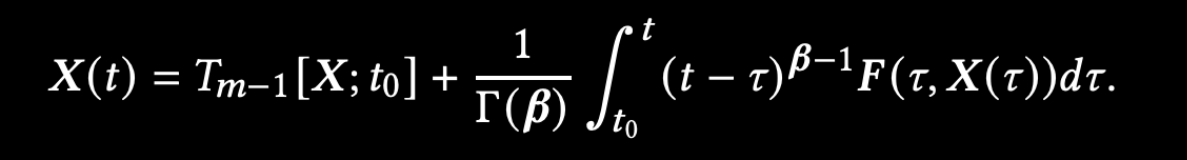

None
torch.Size([1, 160, 1187])

Predicted formula:
 <S> X ( t ) = T _ { m - 1 } [ X ; t _ { 0 } ] + \frac { 1 } { \Gamma ( { \cal { \rho } } ) } \int _ { t _ { 0 } } ^ { t } ( t - \tau ) ^ { { \cal { F } } - 1 } F ( \tau , X ( \tau ) ) d \, \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 338, 3)


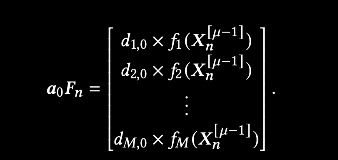

None
torch.Size([1, 160, 338])

Predicted formula:
 <S> a _ { u } F _ { n } = \left[ \begin{array} { c } { d u _ { 1 } \times K _ { 2 } K ( X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } ^ { ( L - 1 ) } } \\ { d _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { 2 } X _ { i } X _


<IPython.core.display.Math object>

None
(160, 960, 3)


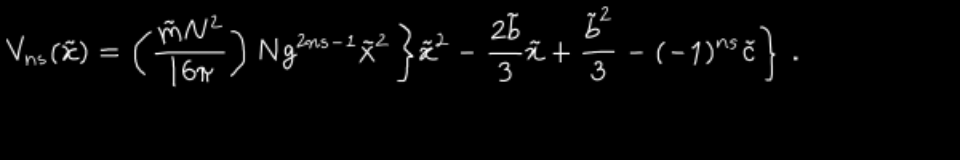

None
torch.Size([1, 160, 960])

Predicted formula:
 <S> \chi _ { \mathrm { v o t } } ( \tilde { \cal E } ) = \left( \frac { \tilde { \nabla } \sqrt { 2 } } { | 6 \pi } \right) \propto 9 ^ { 2 m _ { s - 1 } } \tilde { \lambda } ^ { 2 m _ { s } - 4 } \tilde { \lambda } ^ { 2 } \tilde { \xi } - \frac { 2 \tilde { \sigma } } { 2 } \tilde { \kappa } + \frac { \tilde { z } ^ { 2 } } { 2 } \tilde { \kappa } + \frac { \tilde { z } ^ { 2 } } { 8 } - ( -


<IPython.core.display.Math object>

None
(160, 960, 3)


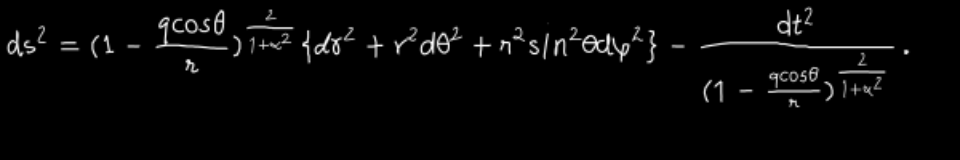

None
torch.Size([1, 160, 960])

Predicted formula:
 <S> \mathrm { d s } ^ { 2 } = ( 1 - \mathrm { ~ f o s } ) ^ { \frac { 2 } { 1 + \omega } } | + \zeta d \alpha ^ { 2 } + V ^ { 2 } s | \alpha ^ { 2 } + m ^ { 2 } \oplus l n ^ { 2 } \Theta ^ { 4 } \} - \frac { \mathrm { s t o s t } } { \sqrt { - \frac { \mathrm { s t s t s t } } { \pi } } ) ^ { 2 } } { \{ 1 - \frac { \mathrm { s t s t s t } { \infty


<IPython.core.display.Math object>

None
(160, 729, 3)


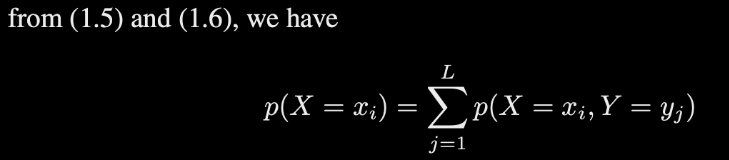

None
torch.Size([1, 160, 729])

Predicted formula:
 <S> \mathrm { f o m } \left( 1 , 5 \right) \mathrm { a n d } \left( 1 , 6 \right) , \mathrm { w e n e } \right) \sum _ { j = 1 } ^ { L } p \left( X = x _ { i } \right) = \sum _ { j = 1 } ^ { L } p \left( X = x _ { i } , Y = y _ { j } \right) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 4080, 3)


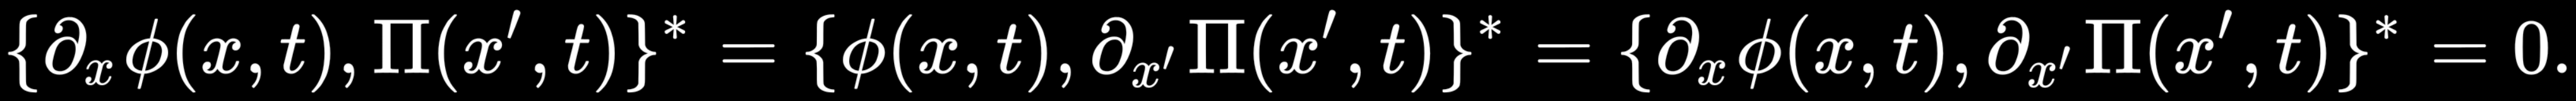

None
torch.Size([1, 160, 4080])

Predicted formula:
 <S> \{ \partial _ { x } \phi ( x , t ) , \Pi ( x ^ { \prime } , t ) \} ^ { * } = \{ x ^ { \prime } , t ) \} ^ { * } = <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 5052, 3)


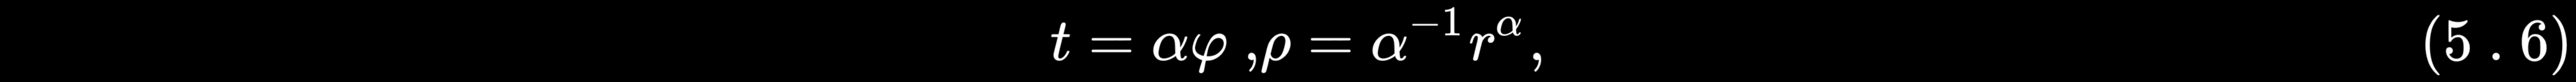

None
torch.Size([1, 160, 5052])

Predicted formula:
 <S> \begin{array} { c c } { } & { } \\ { } & { } \\ \end{array} { } & { } \\ \end{array} { } & { } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(160, 12242, 3)


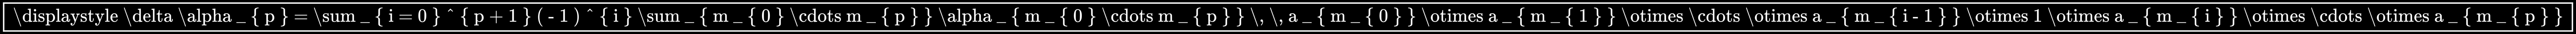

None
torch.Size([1, 160, 12242])

Predicted formula:
 <S> \Box \underbrace { { ( \mathrm { d i s y s t y u e s } ) } } { } _ { } { } { } { } { } { } { } { } { } { } { } { } { } { } { } { { \mathbb { M } } } { { } } { { } } { } { } { } { } { } { { } } { { } } { { { } } } { { { { { 1 } } } { { { { { { { { { 1 } } } } } } } { { { { { { { { {


<IPython.core.display.Math object>

None


In [12]:
for image in IMAGES:
    predict_scaled(image)